###Data Loading

###Text Semantics based product similarity

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


: 

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
# Navigate to a specific directory in Google Drive
os.chdir('/content/drive/My Drive/AmazonProductRecommendation/pickels')


In [12]:
data = pd.read_pickle('28k_apperal_data_preprocessed')

In [13]:
data.shape

(28385, 7)

In [14]:
'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 1    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

'''


'\n# Set values for various parameters\nnum_features = 300    # Word vector dimensionality\nmin_word_count = 1    # Minimum word count\nnum_workers = 4       # Number of threads to run in parallel\ncontext = 10          # Context window size\ndownsampling = 1e-3   # Downsample setting for frequent words\n\n# Initialize and train the model (this will take some time)\nfrom gensim.models import word2vec\nprint ("Training model...")\nmodel = word2vec.Word2Vec(sen_corpus, workers=num_workers,             size=num_features, min_count = min_word_count,             window = context)\n\n'

In [16]:
# Navigate to a specific directory in Google Drive
hand = os.chdir('/content/drive/My Drive/AmazonProductRecommendation')

In [18]:
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [19]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title

    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted

    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)



    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1])
    fig = plt.figure(figsize=(15,15))

    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)

    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)

    plt.show()

In [20]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0

    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [21]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      # we will display it in notebook
      plt.imshow(img)
    except:
      pass

#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1])
        fig = plt.figure(figsize=(25,3))

        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title

        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)

        # displays combine figure ( heat map and image together)
        plt.show()

def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models,
        # 1. bag_of_words
        # 2. tfidf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys())

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0
    values = [vec2[x] for x in vec2.keys()]

    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)



    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b

    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

**Avg w2V**

In [22]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc
w2v_title = np.array(w2v_title)

In [23]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus

    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)



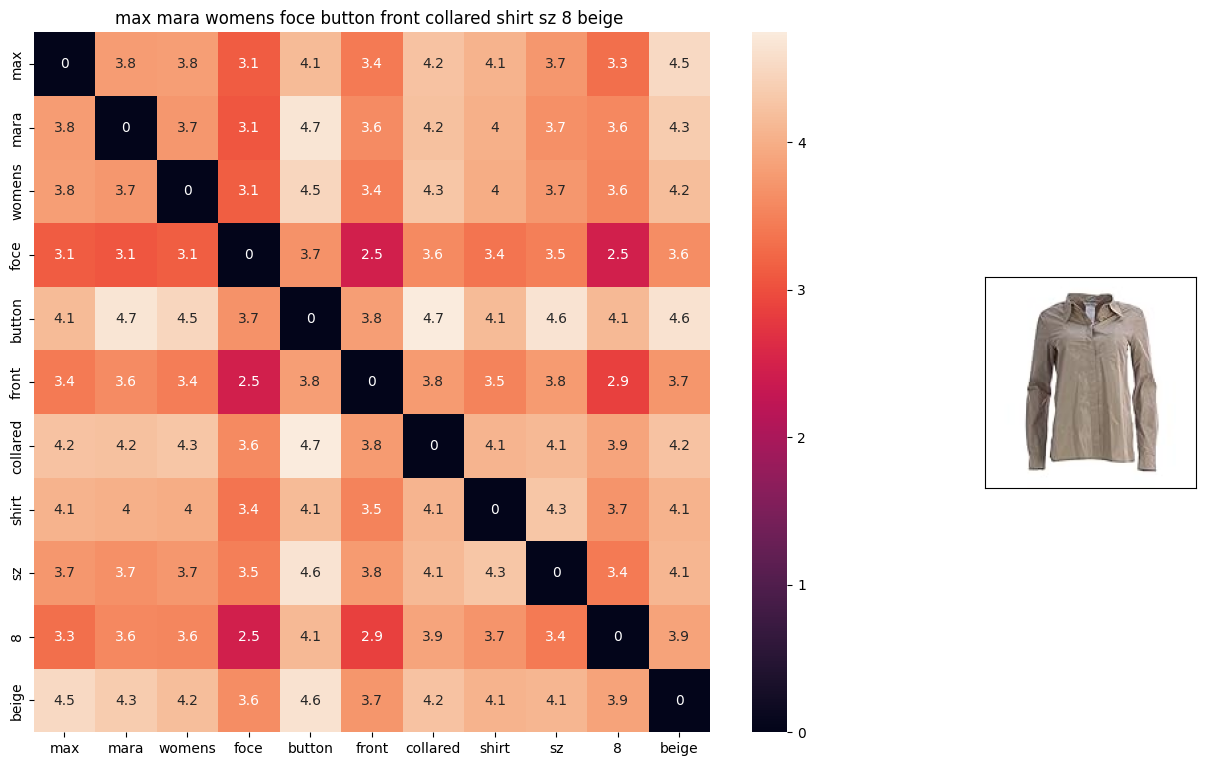

ASIN : B0749S36YR
BRAND : MaxMara
euclidean distance from given input image : 0.0


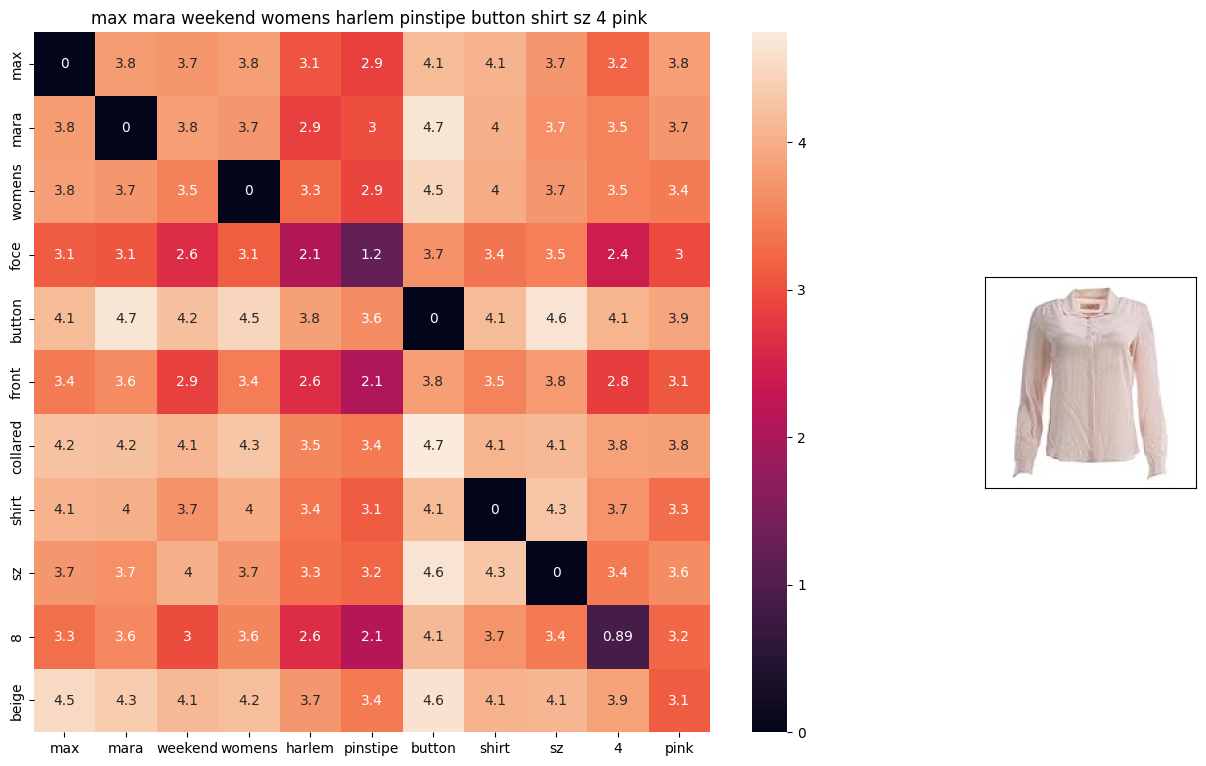

ASIN : B0749S8BQ7
BRAND : MaxMara
euclidean distance from given input image : 0.5466822


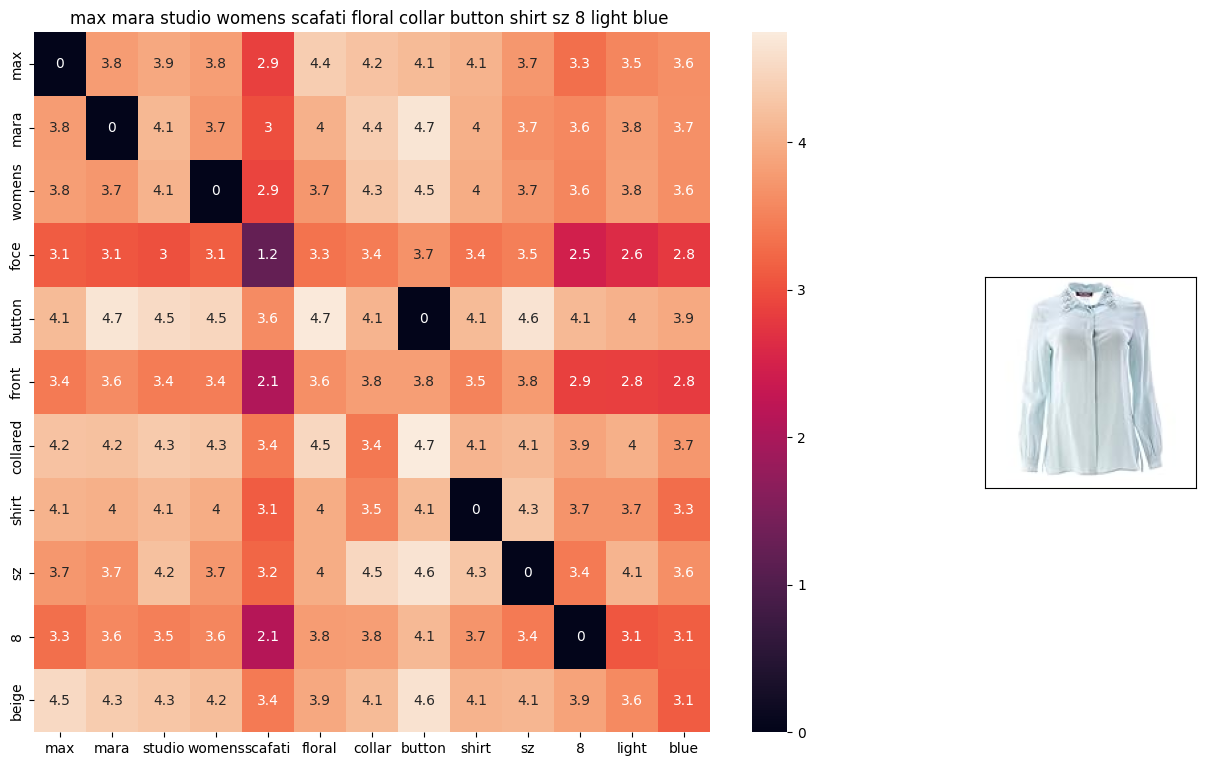

ASIN : B06XH7N85D
BRAND : MaxMara
euclidean distance from given input image : 0.56413823


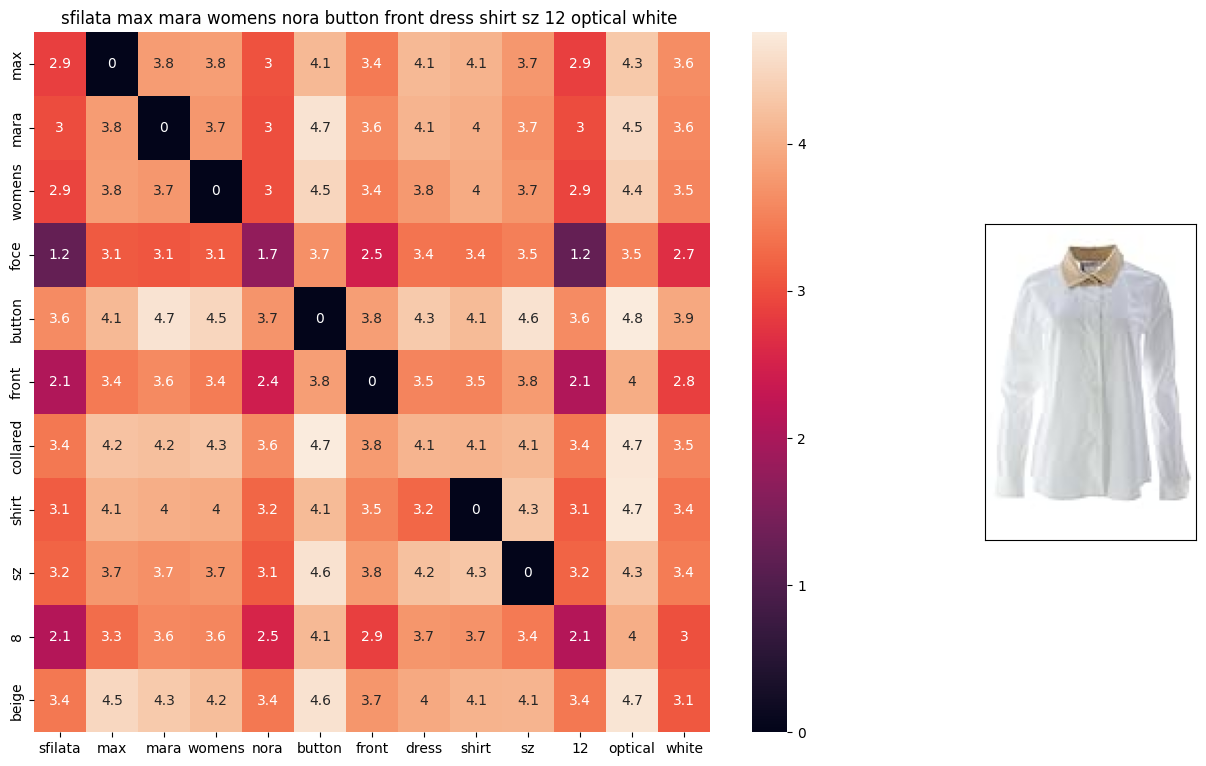

ASIN : B01N6AWF0N
BRAND : MaxMara
euclidean distance from given input image : 0.5824607


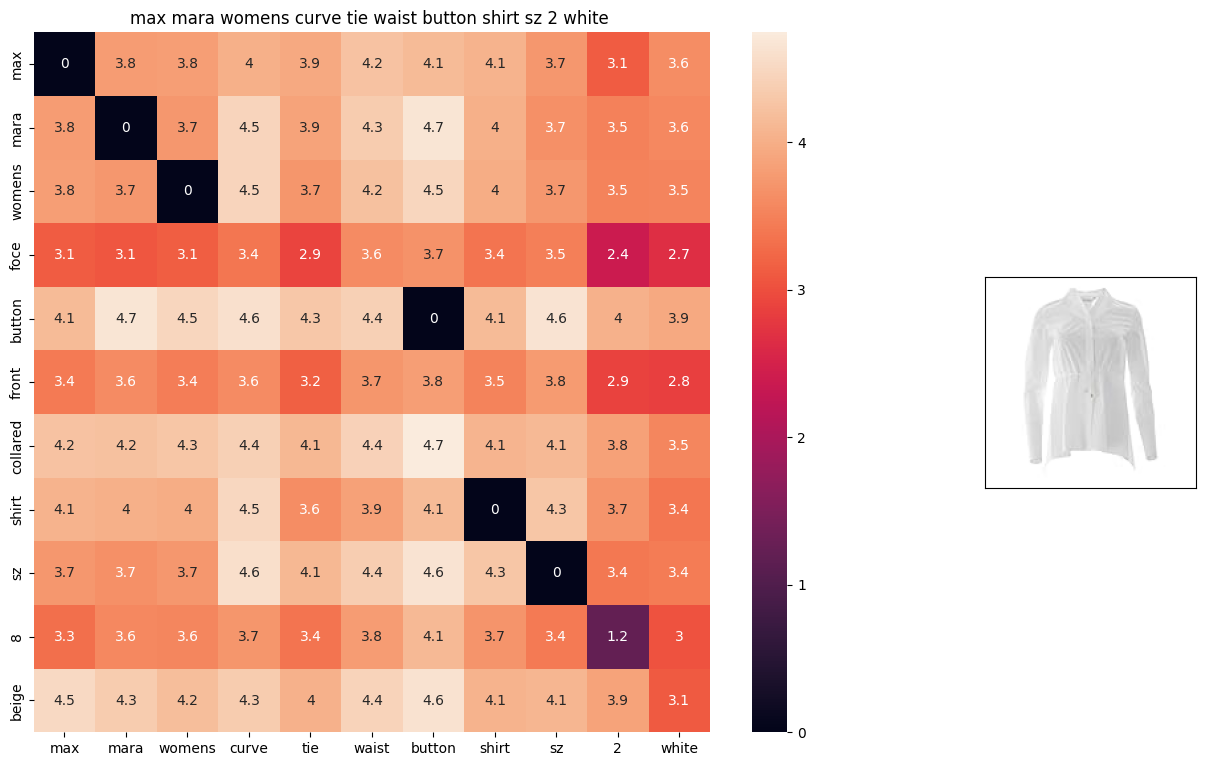

ASIN : B06WWJQ3P2
BRAND : MaxMara
euclidean distance from given input image : 0.6246925


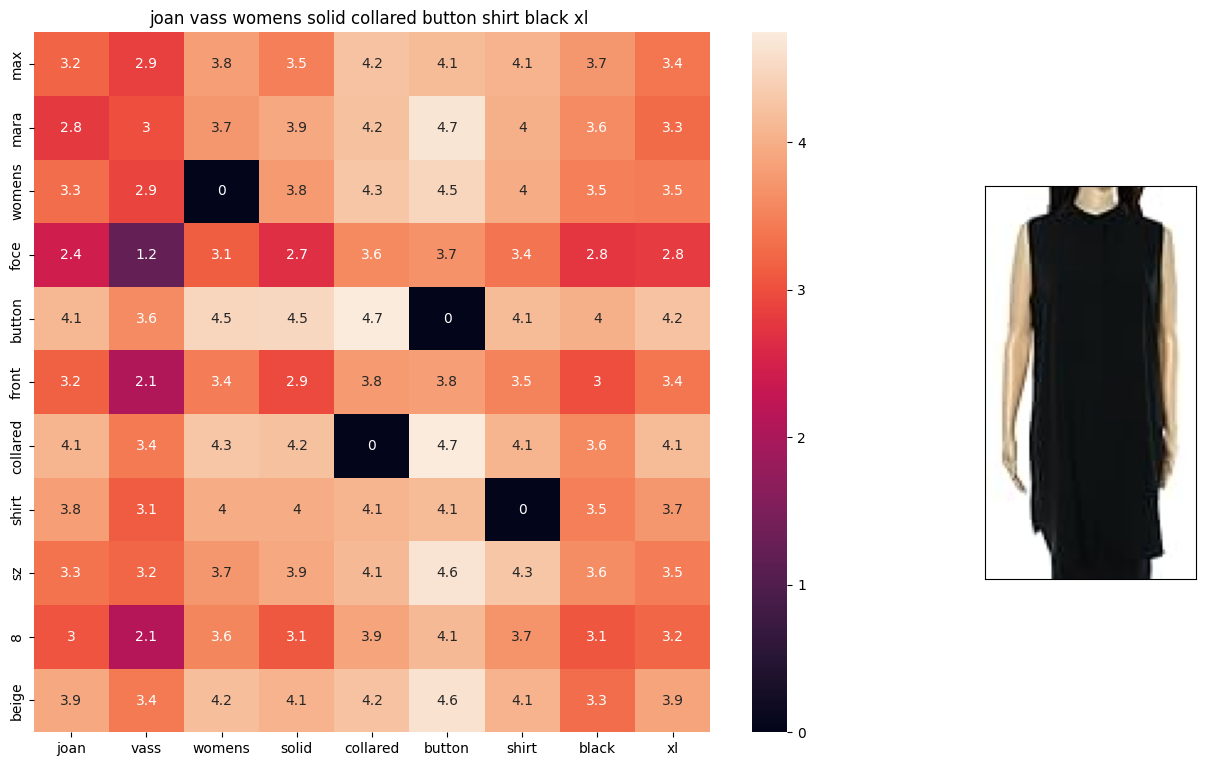

ASIN : B074VBFQ1X
BRAND : Joan Vass
euclidean distance from given input image : 0.6629441


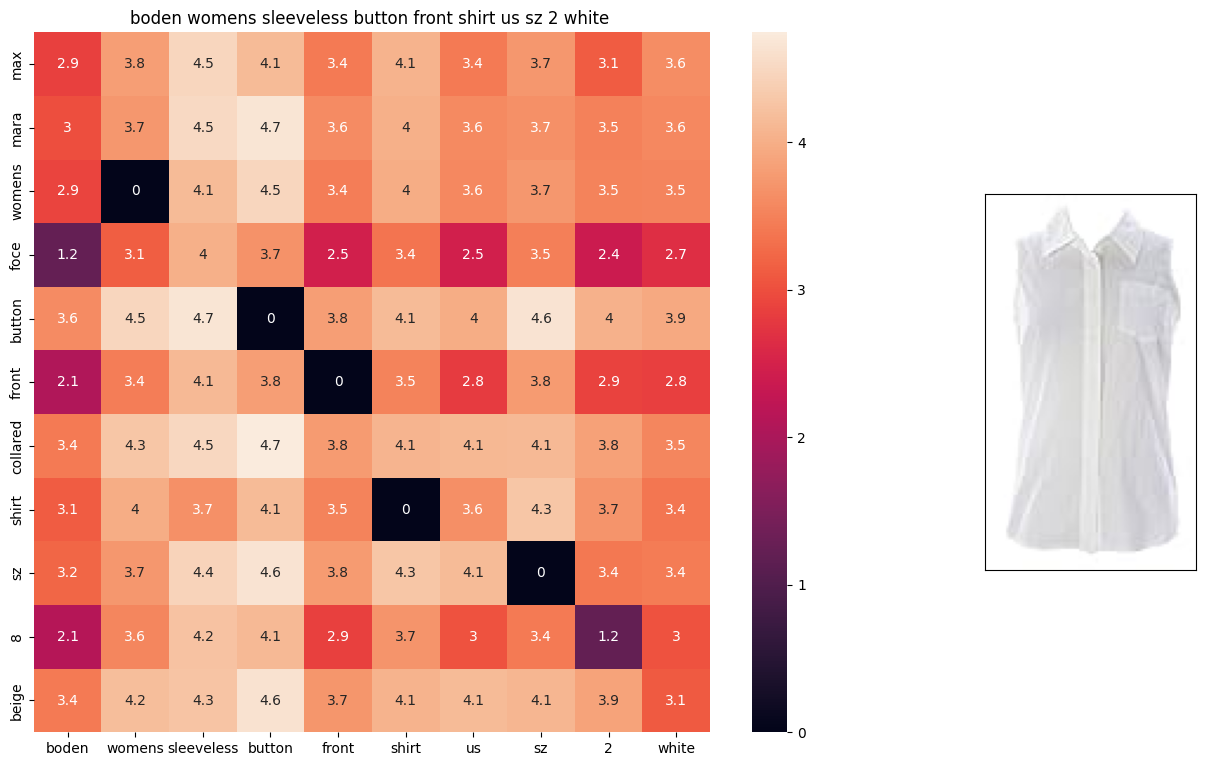

ASIN : B01H62U75W
BRAND : BODEN
euclidean distance from given input image : 0.67210203


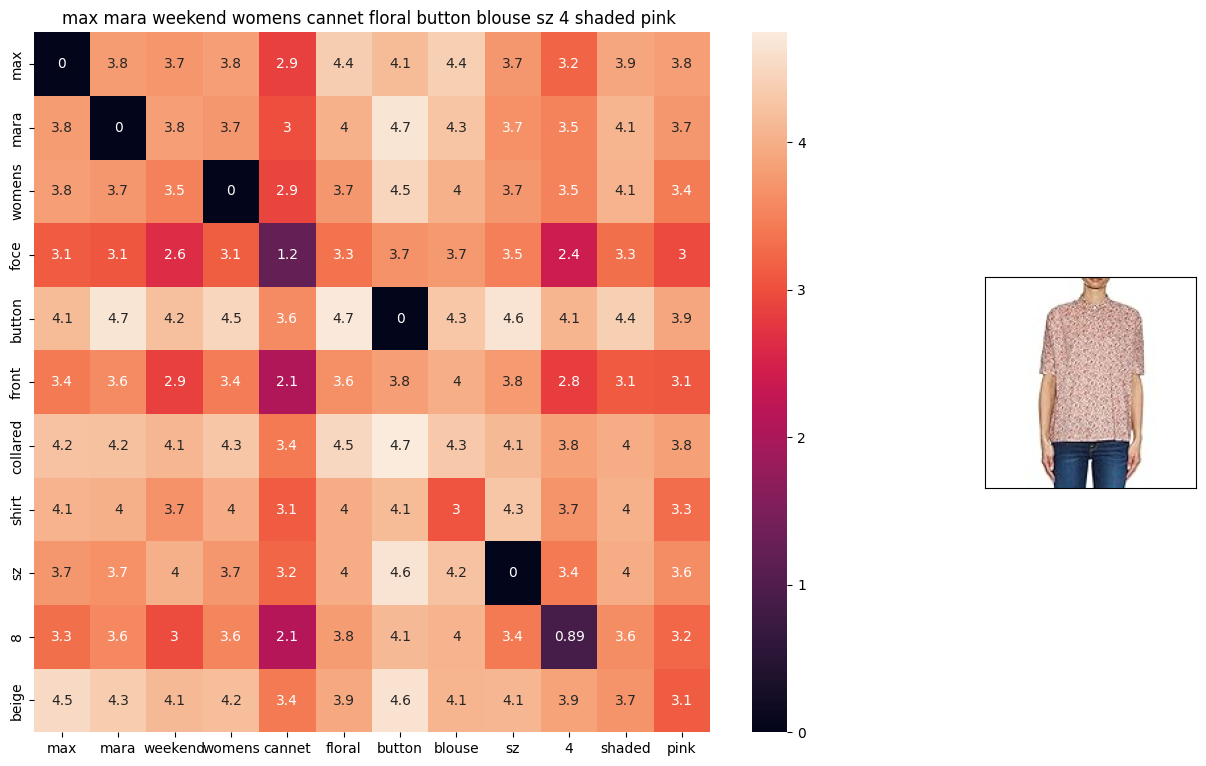

ASIN : B0713WJH8J
BRAND : MaxMara
euclidean distance from given input image : 0.683017


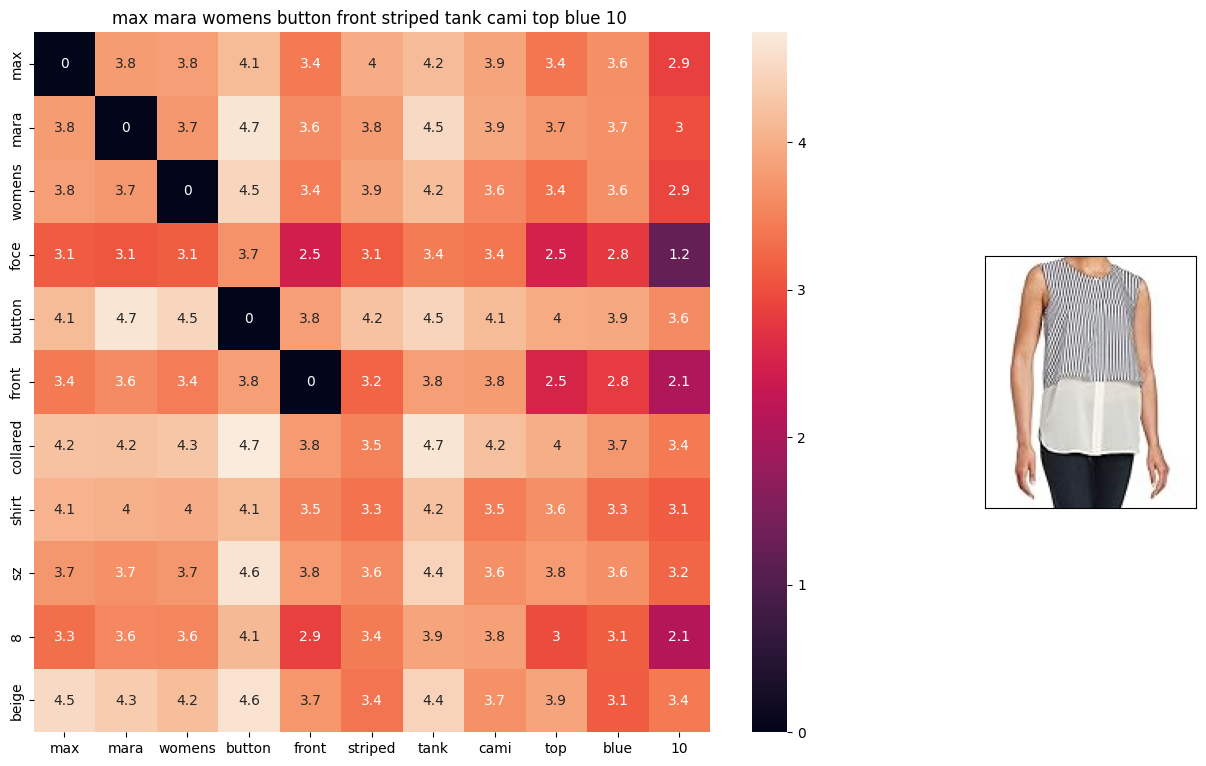

ASIN : B0758KDRF8
BRAND : MaxMara
euclidean distance from given input image : 0.70455915


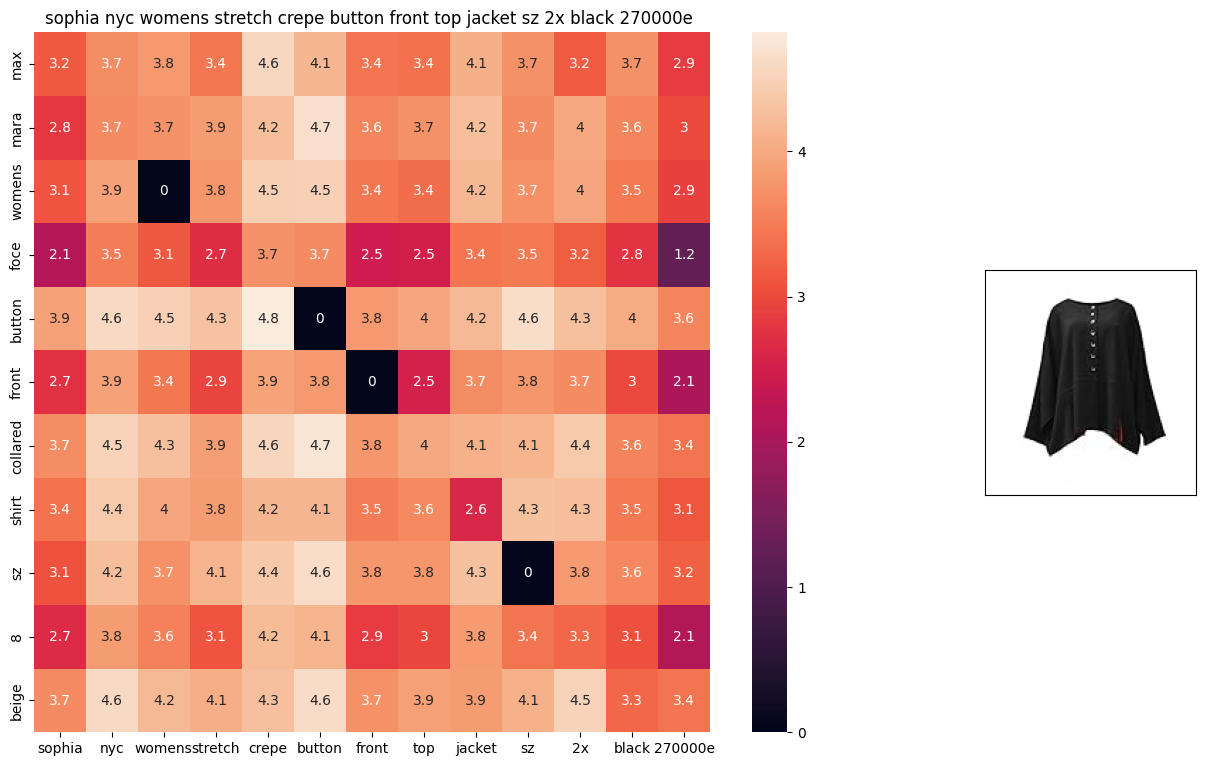

ASIN : B07522YS8B
BRAND : Sophia NYC
euclidean distance from given input image : 0.7095665


In [24]:
avg_w2v_model(19584, 10)

Brand and Colour based

In [25]:
# some of the brand values are empty.
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [30]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


In [31]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc
w2v_title_weight = np.array(w2v_title_weight)

In [53]:
import plotly.figure_factory as ff
import plotly.offline

def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):

    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted

    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    # create a table with the apparel data
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features

    # define colorscale for table headings
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']]

    # create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)

    # plot the table
    plotly.offline.iplot(table, filename='simple_table')

    # create subplots for image display
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    # remove grid lines and axis labels from image subplot
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # pass the url to display the image
    display_img(url, ax, fig)

    plt.show()


In [57]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the cosine distance is measured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist = (w1 * idf_w2v_dist +  w2 * ex_feat_dist) / float(w1 + w2)

    # np.argsort will return indices of num_results smallest distances
    indices = np.argsort(pairwise_dist.flatten())[:num_results]
    # pdists will store the num_results smallest distances
    pdists = np.sort(pairwise_dist.flatten())[:num_results]

    # data frame indices of the num_results smallest distance's
    df_indices = list(data.index[indices])

    for i in range(num_results):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],
                           data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],
                           df_indices[0], df_indices[i], 'weighted')
        print('ASIN:', data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Euclidean distance from input:', pdists[i])
        print('=' * 125)


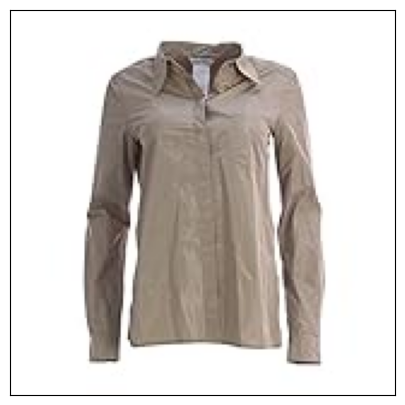

ASIN: B0749S36YR
Brand: MaxMara
Euclidean distance from input: 0.0


ASIN: B0749S4BCF
Brand: MaxMara
Euclidean distance from input: 0.8152288436889649


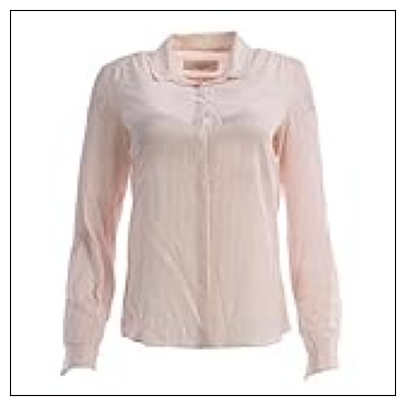

ASIN: B0749S8BQ7
Brand: MaxMara
Euclidean distance from input: 0.8322388014408527


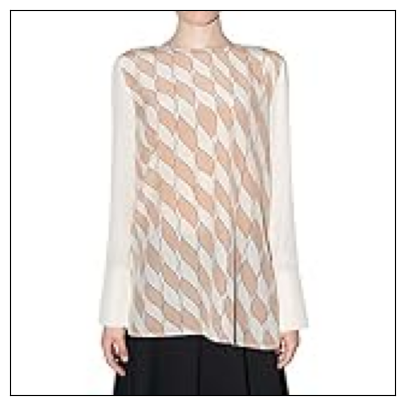

ASIN: B06XG2TBRQ
Brand: MaxMara
Euclidean distance from input: 0.8460259119669596


ASIN: B06WWJQ3P2
Brand: MaxMara
Euclidean distance from input: 0.8829608918440915


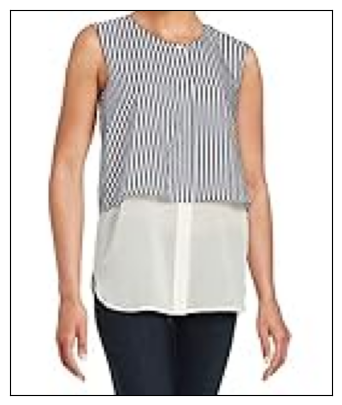

ASIN: B0758KDRF8
Brand: MaxMara
Euclidean distance from input: 0.9115770976953286


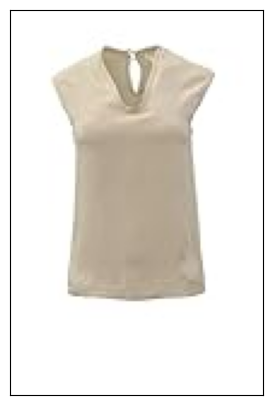

ASIN: B01H28M1PY
Brand: S' MAXMARA
Euclidean distance from input: 0.9289309819539388


ASIN: B01N6AWF0N
Brand: MaxMara
Euclidean distance from input: 0.9327961945843197


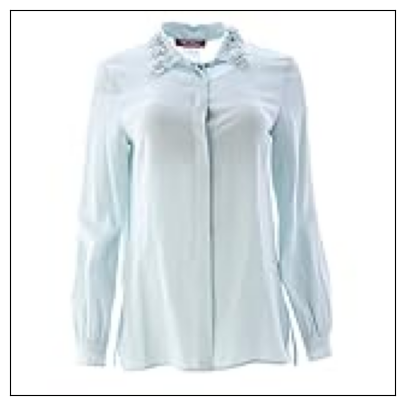

ASIN: B06XH7N85D
Brand: MaxMara
Euclidean distance from input: 0.9523819311769304


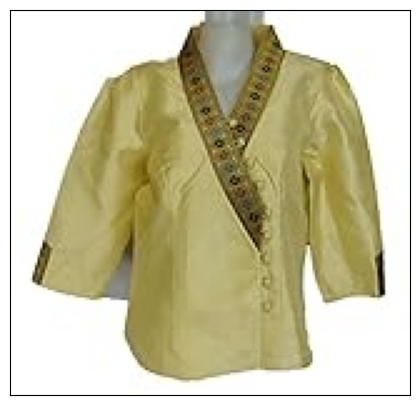

ASIN: B074GW9NFK
Brand: Nanon
Euclidean distance from input: 0.9540040335270343


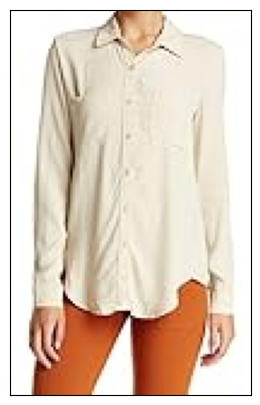

ASIN: B01MDV5OBL
Brand: Rode
Euclidean distance from input: 0.9572168669315754


ASIN: B0749RNWZ3
Brand: MaxMara
Euclidean distance from input: 0.9594673475834308


ASIN: B0749RYBKK
Brand: MaxMara
Euclidean distance from input: 0.9689012846561847


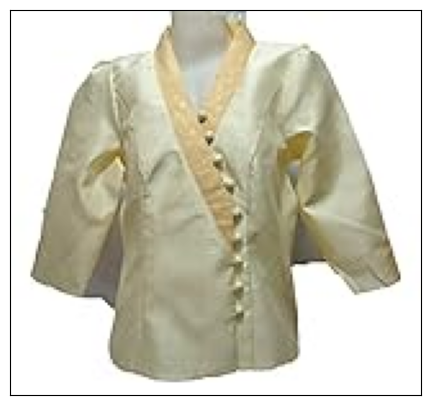

ASIN: B01LW6G077
Brand: Nanon
Euclidean distance from input: 0.9746739706608234


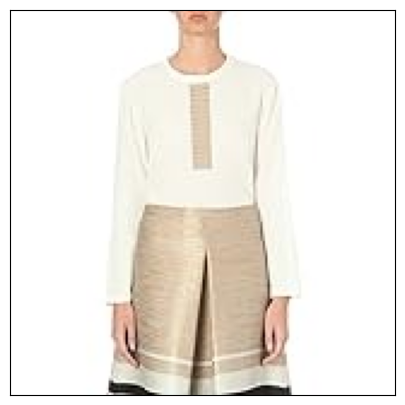

ASIN: B06XG5RGNS
Brand: MaxMara
Euclidean distance from input: 0.9760585150333819


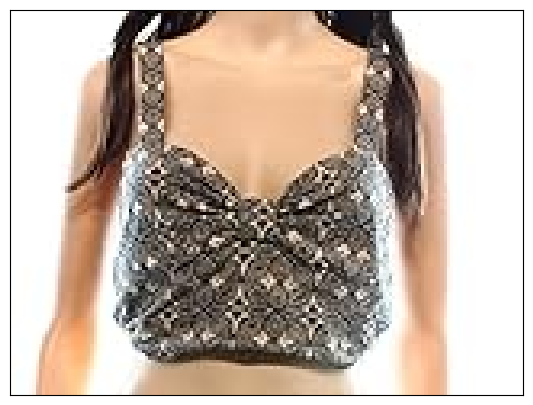

ASIN: B072LWC3WD
Brand: Chloe K.
Euclidean distance from input: 0.9851454418115395


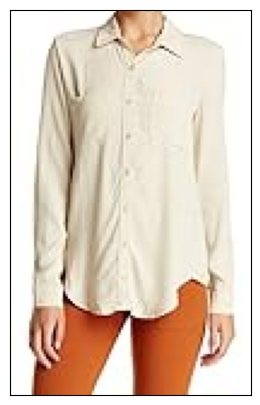

ASIN: B01K4OUKME
Brand: Rode
Euclidean distance from input: 0.9994077047916827


ASIN: B07214YVP2
Brand: Pleione
Euclidean distance from input: 1.003689638894059


ASIN: B074GZMSTS
Brand: Nanon
Euclidean distance from input: 1.0062243780704914


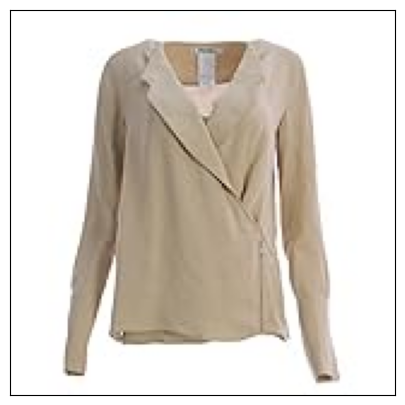

ASIN: B0749S3Z13
Brand: MaxMara
Euclidean distance from input: 1.0067089717798012


In [58]:
idf_w2v_brand(19584, 10, 5, 20)

In [107]:
def idf_w2v_brand(brand_name, w1, w2, num_results):
    # brand_name: brand name of the apparel in the given corpus
    # w1: weight for w2v features
    # w2: weight for brand and color features

    # Find the index of the product with the specified brand name
    brand_indices = data[data['brand'] == brand_name].index

    if len(brand_indices) == 0:
        print("No products found for the specified brand. But you might also like...")
        # If no products with the specified brand are found, recommend similar products
        brand_indices = [0]  # Consider the first product as a fallback

    doc_id = brand_indices[0]  # Consider the first product with the specified brand

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the cosine distance is measured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist = (w1 * idf_w2v_dist +  w2 * ex_feat_dist) / float(w1 + w2)

    # np.argsort will return indices of num_results smallest distances
    indices = np.argsort(pairwise_dist.flatten())[:num_results]
    # pdists will store the num_results smallest distances
    pdists = np.sort(pairwise_dist.flatten())[:num_results]

    # data frame indices of the num_results smallest distance's
    df_indices = list(data.index[indices])

    for i in range(num_results):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],
                           data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],
                           df_indices[0], df_indices[i], 'weighted')
        print('ASIN:', data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Euclidean distance from input:', pdists[i])
        print('=' * 125)


No products found for the specified brand. But you might also like...


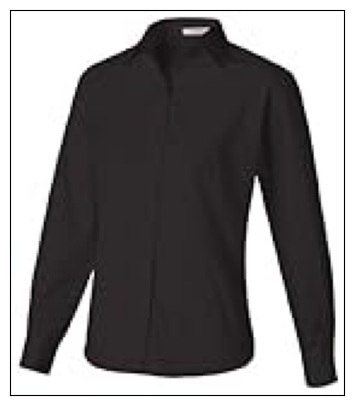

ASIN: B004GSI2OS
Brand: FeatherLite
Euclidean distance from input: 0.0


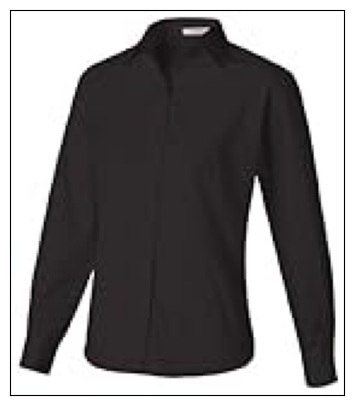

ASIN: B004GSN1EE
Brand: FeatherLite
Euclidean distance from input: 0.17798468271891277


ASIN: B003BTL8EY
Brand: FeatherLite
Euclidean distance from input: 0.8935827597291764


ASIN: B00WDDA534
Brand: Harriton
Euclidean distance from input: 1.0889974594116212


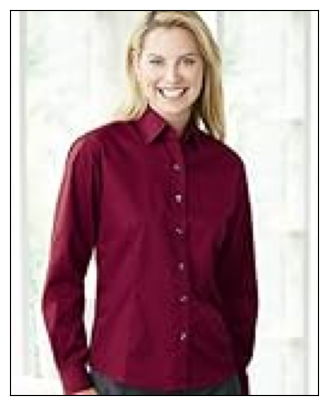

ASIN: B003BTPVEM
Brand: FeatherLite
Euclidean distance from input: 1.0936770806550407


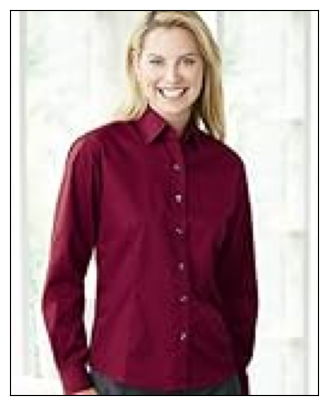

ASIN: B003BTOHHO
Brand: FeatherLite
Euclidean distance from input: 1.0936770806550407


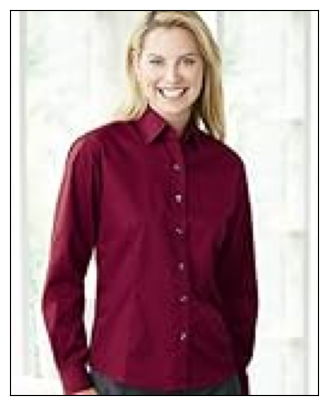

ASIN: B003BTPVGA
Brand: FeatherLite
Euclidean distance from input: 1.0936770806550407


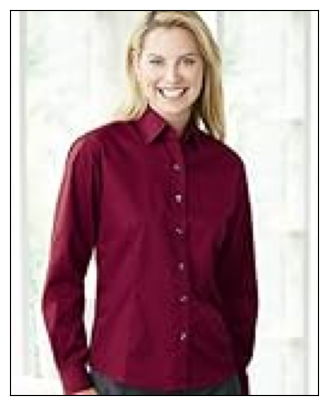

ASIN: B003BTOHG0
Brand: FeatherLite
Euclidean distance from input: 1.0936770806550407


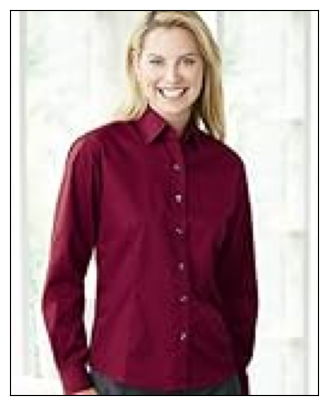

ASIN: B003BTPVHE
Brand: FeatherLite
Euclidean distance from input: 1.0936770806550407


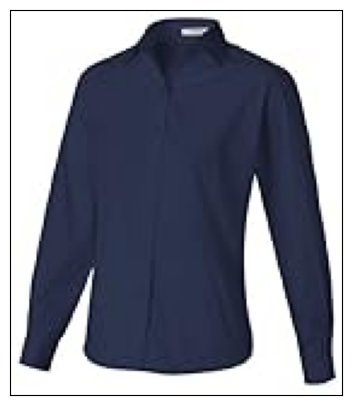

ASIN: B00139HZFU
Brand: FeatherLite
Euclidean distance from input: 1.110625081245047


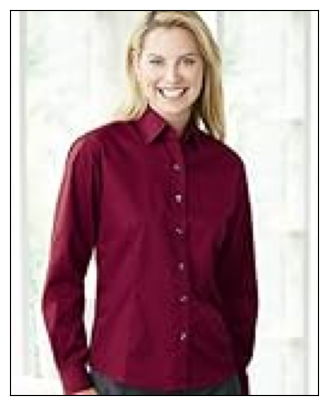

ASIN: B003BTOFOE
Brand: FeatherLite
Euclidean distance from input: 1.1171507567007763


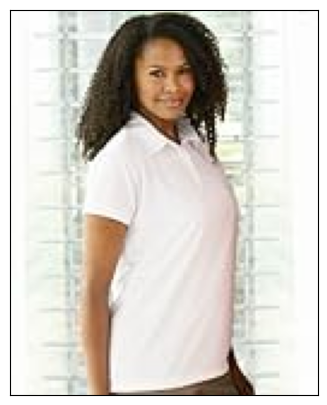

ASIN: B003BSPUCQ
Brand: FeatherLite
Euclidean distance from input: 1.1177338919254718


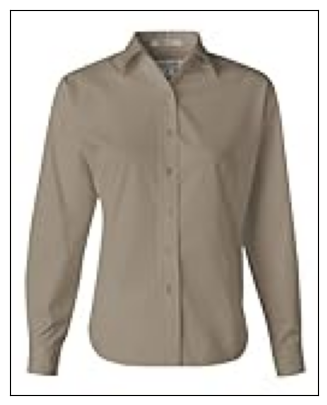

ASIN: B007C0HVRQ
Brand: FeatherLite
Euclidean distance from input: 1.122347929508636


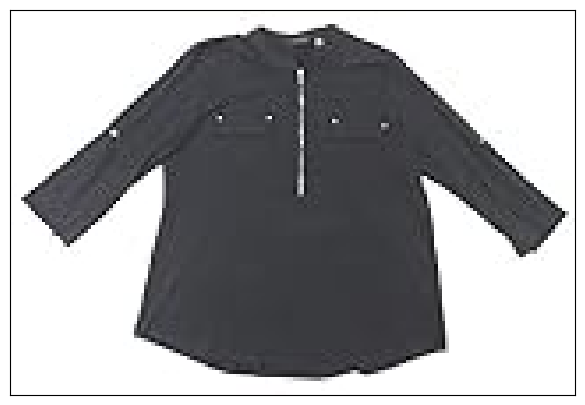

ASIN: B0718Y9J4M
Brand: f
Euclidean distance from input: 1.1944104854575293


ASIN: B017J5O586
Brand: PinRoad
Euclidean distance from input: 1.1947734832763672


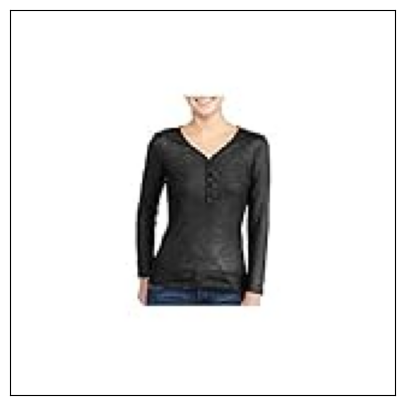

ASIN: B01MTV782F
Brand: Jordache
Euclidean distance from input: 1.2083780288696289


ASIN: B003BSRRDG
Brand: FeatherLite
Euclidean distance from input: 1.2163715999536293


ASIN: B017J5O58G
Brand: PinRoad
Euclidean distance from input: 1.2188083012898763


ASIN: B017J5O55E
Brand: PinRoad
Euclidean distance from input: 1.2188083012898763


ASIN: B017J5O572
Brand: PinRoad
Euclidean distance from input: 1.2245680491129558


In [109]:
idf_w2v_brand("shirt", 10, 5, 20)